# Importing Libraries

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time

* Pandas Options

In [3]:
pd.set_option('max_columns', None)

* Tqdm Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint import

In [5]:
total_df = pd.read_csv('../checkpoints/litho_data_3.csv.gz', compression='gzip') # already non-null litho classes

In [6]:
total_df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME,DRDN,AI,LITHOLOGY_GEOLINK_2,LITHOLOGY_GEOLINK_3
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,6,2215.917725,15_9-12,7.184164,317.241248,5,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,6,2216.070068,15_9-12,6.203159,302.098359,5,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,6,2216.222412,15_9-12,4.952206,283.411635,5,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,6,2216.375000,15_9-12,4.664760,268.071435,5,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,6,2216.527344,15_9-12,5.164095,262.514429,5,5


* Classes Balance

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

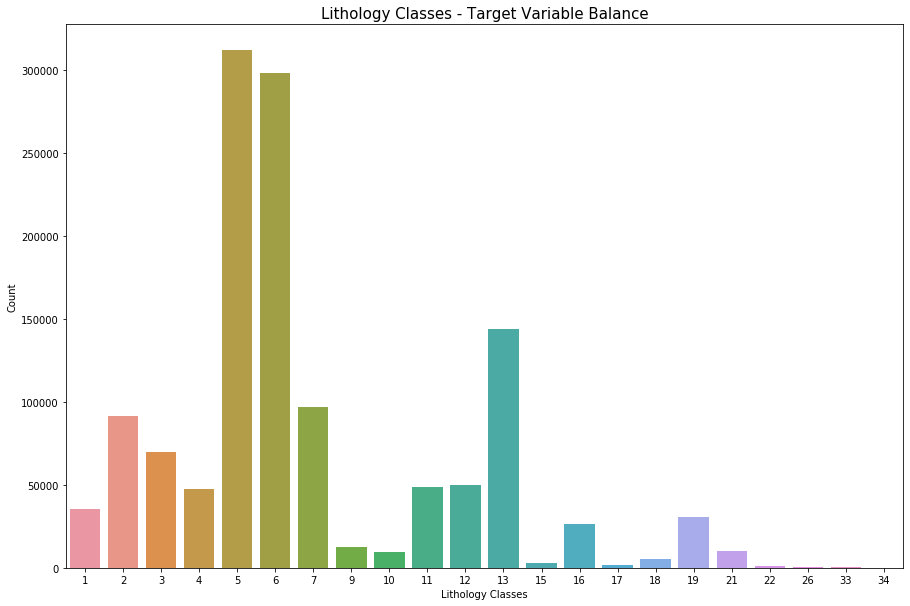

In [7]:
plt.figure(figsize=(15,10))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)

* Merging Some Classes for better geological behavior

In [8]:
total_df['LITHOLOGY_GEOLINK_2'] = total_df['LITHOLOGY_GEOLINK']

for code in tqdm_notebook(total_df.index, desc='Regrouping lithologies'):

    if (total_df['LITHOLOGY_GEOLINK_2'][code] == 2 or total_df['LITHOLOGY_GEOLINK_2'][code] == 3):

        total_df['LITHOLOGY_GEOLINK_2'][code] = 1

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 6:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 5

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 34:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 33


    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 13:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 12

    else:
        
        pass

Text(0.5, 1.0, 'Condensed Lithology Classes - Target Variable Balance')

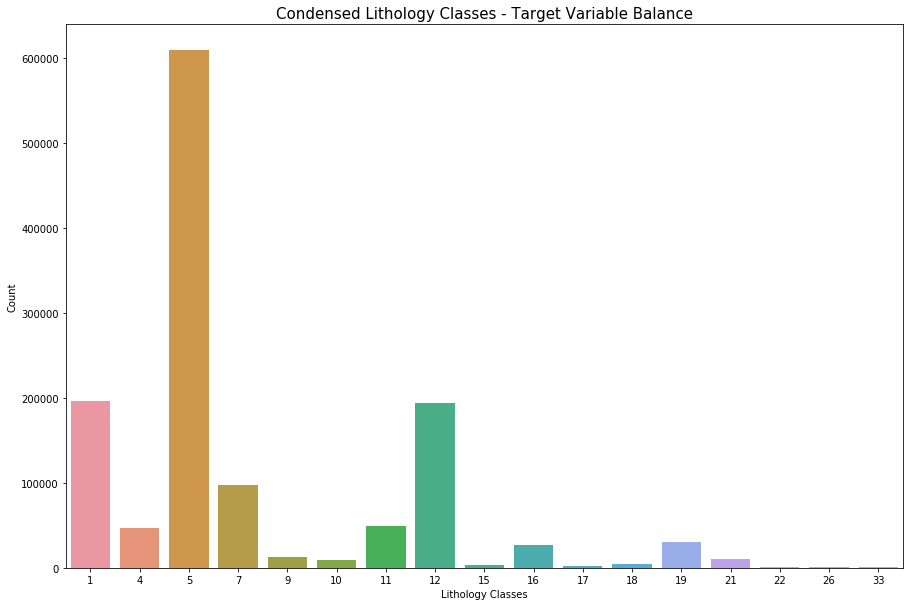

In [9]:
plt.figure(figsize=(15,10))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK_2'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK_2'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Condensed Lithology Classes - Target Variable Balance', fontsize=15)

# Lithology Code Prediction

* LITHOLOGY_GEOLINK non NULL data

In [10]:
litho_data = total_df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK', 'LITHOLOGY_GEOLINK_3', 'DRDN', 'AI']) # litho2 optimum set (84.5)

litho_data.head(n=5)

,CALI,NPHI,RHOB,GR,DTC,RDEP,DEPTH,LITHOLOGY_GEOLINK_2
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,2215.917725,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,2216.070068,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,2216.222412,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,2216.375000,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,2216.527344,5


In [11]:
len(litho_data) # samples to build the ML model

1294715

    * Converting LITHOLOGY_GEOLINK to int type

In [12]:
litho_data['LITHOLOGY_GEOLINK_2'] = litho_data['LITHOLOGY_GEOLINK_2'].astype(int)

* Dataset Creation

In [13]:
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK_2')

Y = litho_data['LITHOLOGY_GEOLINK_2'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

In [14]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (647357, 7) (647357,)
### Test Dataset: ###  (647358, 7) (647358,)


* Model Selection

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_validate

class_pipelines = []

class_pipelines.append(('ScaledRidge', Pipeline([('Scaler', RobustScaler()),('Ridge', linear_model.RidgeClassifier())])))
class_pipelines.append(('ScaledSGDCls', Pipeline([('Scaler', RobustScaler()),('SGDCls', linear_model.SGDClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledKNNCls', Pipeline([('Scaler', RobustScaler()),('KNNCls', KNeighborsClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledDTC', Pipeline([('Scaler', RobustScaler()),('DTC', DecisionTreeClassifier())])))
class_pipelines.append(('ScaledRFC', Pipeline([('Scaler', RobustScaler()),('RFC', RandomForestClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledXGB', Pipeline([('Scaler', RobustScaler()),('XGB', XGBClassifier(tree_method='gpu_hist', gpu_id=0))])))
class_pipelines.append(('ScaledCAT', Pipeline([('Scaler', RobustScaler()),('CAT', CatBoostClassifier(verbose=False, task_type='GPU', devices='0-2'))])))
class_pipelines.append(('ScaledLGBM', Pipeline([('Scaler', RobustScaler()),('LGBM', LGBMClassifier(n_jobs=60))])))


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

results = []

names = []

for name, model in tqdm_notebook(class_pipelines, desc='Cross-Validation Procedure'):

    kfold = KFold(n_splits=5, random_state=42)

    scorers = {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score), 'f1': make_scorer(f1_score, average='macro')}

    final_scorers = cross_validate(model, x_train, y_train, cv=kfold, scoring=scorers)
    results.append(final_scorers)
    names.append(name)
    print(name, 'Acc: ', final_scorers['test_accuracy'].mean(), '\\', final_scorers['test_accuracy'].std(), '\n')
    print(name, 'BalAcc: ', final_scorers['test_balanced_accuracy'].mean(), '\\', final_scorers['test_balanced_accuracy'].std(), '\n')
    print(name, 'F1: ', final_scorers['test_f1'].mean(), '\\', final_scorers['test_f1'].std(), '\n')


ScaledRidge Acc:  0.54946497905382 \ 0.0005844048699294004 

ScaledRidge BalAcc:  0.11643018052697118 \ 0.0006082760479255434 

ScaledRidge F1:  0.11038084149697258 \ 0.0006560501789421723 

ScaledSGDCls Acc:  0.5506034659229109 \ 0.004453528668025522 

ScaledSGDCls BalAcc:  0.16688166493408613 \ 0.00905182341579835 

ScaledSGDCls F1:  0.17307980999529535 \ 0.011006731983621463 

ScaledKNNCls Acc:  0.8626955437424817 \ 0.0008779098985301785 

ScaledKNNCls BalAcc:  0.7451193279325874 \ 0.0016483223429686654 

ScaledKNNCls F1:  0.7775772043905496 \ 0.0013888677635921633 

ScaledDTC Acc:  0.8392262679593454 \ 0.0008574946663813805 

ScaledDTC BalAcc:  0.7914249203742761 \ 0.0022522065088064072 

ScaledDTC F1:  0.7929162891101997 \ 0.0017668380459574375 

ScaledRFC Acc:  0.8824744325847786 \ 0.001325966074501053 

ScaledRFC BalAcc:  0.803060675335597 \ 0.002657521070520009 

ScaledRFC F1:  0.8459633817050115 \ 0.002162622519910914 

ScaledXGB Acc:  0.8203186194475773 \ 0.000558063120656816

* Hyperparameter Tunning

    * Defining the Search Space

In [17]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


space ={'max_depth': hp.choice("x_max_depth", np.arange(10, 110, 10, dtype=int)),
        'n_estimators': hp.choice ('x_n_estimators',  np.arange(100, 2000, 10, dtype=int)),
        'max_features': hp.choice ('x_max_features', ['auto', 'sqrt']),
        'min_samples_split' : hp.choice ('x_min_samples_split', [2, 5, 10, 15]),
        'min_samples_leaf' : hp.choice ('x_min_samples_leaf', [1, 2, 5, 8, 10]),
        'bootstrap' : hp.choice ('x_bootstrap', [True, False]),
        'n_jobs' : hp.choice ('x_n_jobs', [-1])
    }


    * Defining Objective Function

In [18]:
def objective(space):
    # Instantiate the classifier
    clf = RandomForestClassifier(**space)
        
    # Fit the classsifier
    clf.fit(RobustScaler().fit_transform(x_train), y_train)
    
    # Predict on Cross Validation data
    pred = clf.predict(RobustScaler().fit_transform(x_test))
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

    * Running Optimization

In [19]:
start_time = time.time()
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print(best)
print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

100%|██████████| 100/100 [5:24:08<00:00, 194.48s/trial, best loss: -0.8448810553854276]
{'x_bootstrap': 1, 'x_max_depth': 3, 'x_max_features': 0, 'x_min_samples_leaf': 0, 'x_min_samples_split': 0, 'x_n_estimators': 105, 'x_n_jobs': 0}
324.1 minutes taken


* Training Model with Best Parameters (check 'best' variable)

In [21]:
start_time = time.time()

best_rfc = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=950, max_features='auto', min_samples_split=2, bootstrap=False, n_jobs=60) # the rest of the best parameters are  the default ones

best_rfc.fit(RobustScaler().fit_transform(x_train), y_train)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

3.1 minutes taken


    * Model Accuracy Test

In [22]:
start_time = time.time()

y_predict = best_rfc.predict(RobustScaler().fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.4 minutes taken


In [23]:
print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Micro: ', str(f1_score(y_test, y_predict, average='macro')))

Accuracy:  0.9107170993484285 

######################## 

Balanced Accuracy:  0.8433535544742262
######################## 

F1-Score Micro:  0.8787929945121278


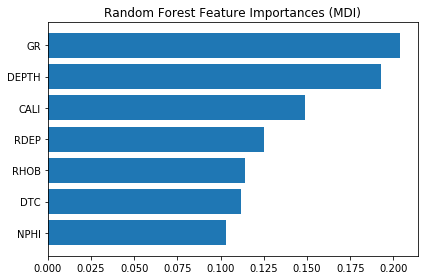

In [24]:
tree_feature_importances = (best_rfc.feature_importances_)
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

    * Confusion Matrix

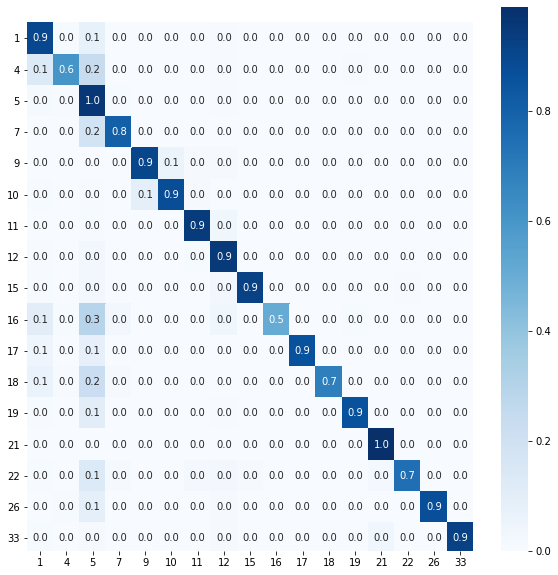

In [25]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], cmap=plt.cm.Blues, annot=True, fmt='.1f', xticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_2'].unique())
, yticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_2'].unique())
) # confusion matrix normalized as in Sklearn documentation

plt.yticks(rotation=0) 

ax.set_ylim(len(cf_matrix)-0.1, -0.5)

plt.show()

    * Null Values Prediction

        * Null Values Dataset 

null_litho_dataset = total_df[pd.isnull(total_df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK'])

        * Prediction

litho_prediction = best_rfc.predict(RobustScaler().fit_transform(null_litho_dataset))

        * Replacing Null Values for Predicted Ones

predicted_litho_dataset = null_litho_dataset

predicted_litho_dataset['LITHOLOGY_GEOLINK'] = litho_prediction

predicted_litho_dataset.head(n=5)

    * Final Dataframe

final_df = litho_data.append(predicted_litho_dataset)

final_df.sort_index(inplace=True)

final_df['WELL_NAME'] = total_df['WELL_NAME'].values

final_df.head(n=5)

# Checkpoints

path_file_final_df = '../checkpoints/final_df.csv.gz'

final_df.to_csv(path_file_final_df,index=False, compression='gzip')